### 1. Importing libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score
)
from utils.utils import split_data
from crack_segmentation.subroutines.loss_metrics import (
    Weighted_Cross_Entropy,
    F1_score_dil,
    F1_score,
    Precision_dil
)

### 2. Loading the dataset

In [2]:
dataset = pd.read_csv('../dataset/dataset_final.csv')

dataset['Filepath'] = dataset['Filepath'].apply(lambda x: '../' + x)

train_df, test_df = train_test_split(
    dataset.sample(frac=1.0, random_state=42),
    train_size=0.80,
    random_state=42
)

preprocess_input = tf.keras.applications.resnet.preprocess_input

train_data, valid_data, test_data = split_data(
        train_df, 
        test_df, 
        image_height=224,
        image_width=224,
        image_channels=1.0, 
        preprocess_input=preprocess_input,
    )

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


### 3. Importing the UNet-ResNet50 model

In [3]:
model = load_model(
    'crack_segmentation/output/checkpoints/unet_resnet50.h5',
    custom_objects={
        'loss': Weighted_Cross_Entropy(10),
        'F1_score': F1_score,
        'F1_score_dil': F1_score_dil,
        'Precision_dil': Precision_dil
    },
    compile=False
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

2024-03-15 18:10:10.342504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-15 18:10:10.372356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cilab_user/surface_crack_detection/cilab/lib/python3.10/site-packages/cv2/../../lib64:
2024-03-15 18:10:10.372376: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-03-15 18:10:10.373096: I tensorflow/core/platfor

### 4. Evaluating the model

In [4]:
loss, acc = model.evaluate(test_data)

250/250 [==============================] - 984s 4s/step - loss: 2.9390 - accuracy: 0.9561


In [5]:
print(f"acc: {acc}")
print(f"loss: {loss}")

acc: 0.956125020980835
loss: 2.9389641284942627


### 5. Making predictions

In [6]:
y_pred = np.argmax(model.predict(test_data), axis=-1)

250/250 [==============================] - 974s 4s/step


In [7]:
print(y_pred)

[0 1 1 ... 0 0 0]


In [8]:
metrics = classification_report(test_data.labels, y_pred)

In [9]:
print(metrics)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      3981
           1       0.98      0.93      0.96      4019

    accuracy                           0.96      8000
   macro avg       0.96      0.96      0.96      8000
weighted avg       0.96      0.96      0.96      8000



In [10]:
x = f1_score(test_data.labels, y_pred, average='weighted')
y = precision_score(test_data.labels, y_pred, average='weighted')
z = recall_score(test_data.labels, y_pred, average='weighted')

In [11]:
print(f'F1 score: {x}')
print(f'Precision: {y}')
print(f'Recall: {z}')

F1 score: 0.9561030268642086
Precision: 0.9572666178699367
Recall: 0.956125


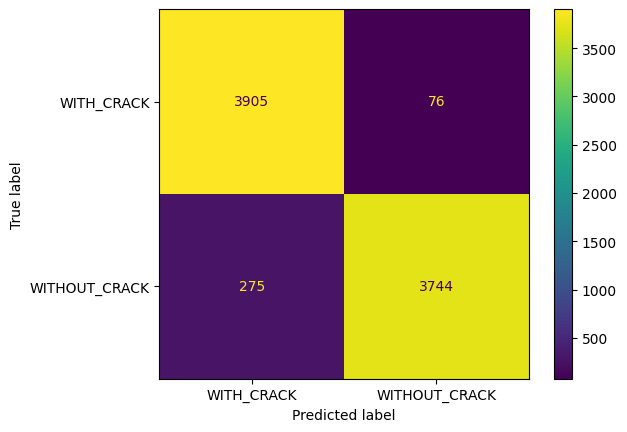

In [12]:
cm = confusion_matrix(test_data.labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['WITH_CRACK', 'WITHOUT_CRACK'])

disp.plot()